In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ruptures as rpt

---
## Question 1

To begin, we will use homogeneous notations through the whole project : the two different intensities will be denoted respectively $a$ and $b$, and not$\lambda_0$ and $\lambda_1$.

Notice that :

$\displaystyle h(s) = \frac{f_{\tau}(s)}{1 - F_{\tau}(s)} = \frac{\sigma e^{-\sigma s}}{e^{-\sigma s}} = \sigma$

It is first very clear that the jumps of $\hat{Z}(t)$ are exactly the ones of $N(t)$ (and are due to the conditionning w.r.t $\displaystyle\mathcal{F}_t$. Let's denote them $(T_1, T_2, ...)$. The equation describing the behavior of $\hat{Z}(t)$ can therefore be written :

$\begin{array}
\displaystyle \hat{Z}(t) &\displaystyle = \int_0^t\sigma\left(1 - \hat{Z}(s)\right)\,ds - \int_0^t(b-a)\hat{Z}\left(s^-\right)\left(1 - \hat{Z}\left(s^-\right)\right)\,ds + \sum_{T_k\leq t}{\frac{(b-a)\hat{Z}\left(T_k^-\right)\left(1 - \hat{Z}\left(T_k^-\right)\right)}{a + (b-a)\hat{Z}\left(T_k^-\right)}} \\
 &\displaystyle = \int_{T_n}^t\left(\sigma - (b-a)\hat{Z}\left(s^-\right)\right)\left(1 - \hat{Z}(s)\right)\,ds + \sum_{T_k\leq t}{\frac{(b-a)\hat{Z}\left(T_k^-\right)\left(1 - \hat{Z}\left(T_k^-\right)\right)}{a + (b-a)\hat{Z}\left(T_k^-\right)}}
\end{array}$

Let's therefore take $t\in\mathbb{R}$ and choose $n\in\mathbb{N}$ such that $t\in\left[T_n, T_{n+1}\right[$. We have :

$\displaystyle \hat{Z}(t) - \hat{Z}(T_n) = \int_{T_n}^t\left(\sigma - (b-a)\hat{Z}\left(s^-\right)\right)\left(1 - \hat{Z}(s)\right)\,ds$

Because the sums cancel each other (there are no new jumps between $T_n$ and $t$, by assumption on $n$), and the common part of the integrals (between $0$ and $T_n$) also cancel.  
Differentiating this equation w.r.t $t$ and assuming that we know $\hat{Z}(T_n)$, we get that on the interval $\left[T_n, T_{n+1}\right[$, $\mathbf{\hat{Z}(t)}$ **is a solution of the following differential equation :**

$\boxed{\displaystyle \dot{y}(t) =  (\sigma - (b-a)y(t))(1 - y(t))\\
y(T_n) =  \hat{Z}(T_n)}$

Using the first equation again, we get that for any $n\in\mathbb{N}$, **the amplitude of the jump at $\mathbf{T_n}$ is given by :**

$\boxed{\displaystyle \hat{Z}\left(T_n\right) - \hat{Z}\left(T_n^-\right) = \frac{(b-a)\hat{Z}\left(T_n^-\right)\left(1 - \hat{Z}\left(T_n^-\right)\right)}{a + (b-a)\hat{Z}\left(T_n^-\right)}}$

Because the integrals cancel each other (integrating w.r.t $s$ between $0$ and $T_n$ or between $0$ and $T_n^-$ is the same thing) and the common terms of the sum ($T_1$, ..., $T_{n-1}$) also cancel.

**Finally, these two boxed equalities allow us to recursively totally determine $\mathbf{\hat{Z}(t)}$ :**
 - **We can compute $\mathbf{\hat{Z}(t)}$ on $\mathbf{[T_n, T_{n+1}[}$ using the differential equation**
 - **We know the value of the jump at $\mathbf{T_{n+1}}$ in terms of $\mathbf{{T_{n+1}}^-}$**

Taking into account that obviously :  
$\displaystyle \mathbf{\hat{Z}(T_0)} = \hat{Z}(0) = \mathbb{P}[\tau \leq 0] = \mathbb{P}[\tau = 0] = \mathbf{0}$  
We can finally compute $\hat{Z}$

---
## Question 2

We first define a function `simulate(a, b, sigma)` that will generate a trajectory of $N$ from $0$ to $2\tau$, with $\tau \sim \mathcal{E}(\sigma)$ being generated inside the function.

In [2]:
def simulate(a, b, sigma):
    tau = np.random.exponential(1/sigma)
    t_max = 2*tau
    res = []
    T = 0
    
    #First we generate N_a
    while T < tau:
        res.append(T)
        T += np.random.exponential(1/a)
    T = tau
    
    #Then we generate N_b
    while T < t_max:
        res.append(T)
        T += np.random.exponential(1/b)
    return np.array(res), tau

In [3]:
#Setting parameters
a = 0.5
b = 1.5
sigma  = 0.01

Tau is : 61.220731340098375


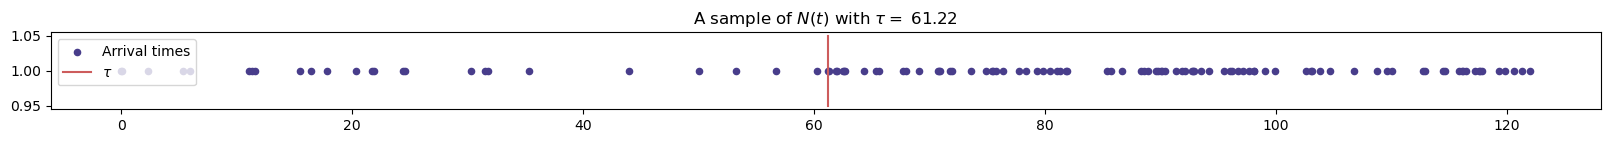

In [4]:
T, tau = simulate(a, b, sigma)
n = len(T)
print('Tau is :', tau)

plt.figure(figsize = (20, 1))
plt.scatter(T, np.ones(n), s = 20, c = 'darkslateblue')
plt.plot([tau] * 10, np.linspace(0.95, 1.05, 10), c="indianred")
plt.legend(["Arrival times", r"$ \tau $"])
plt.title(fr'A sample of $N(t)$ with $\tau = $ {np.round(tau, 2)}')
plt.show()

We then define a function `Z_hat(T, a, b, sigma, L)` that computes $\hat{Z}$ using the equations given in question 1, from the jump times stored in `T`. The argument `L` corresponds to the number of samples we will use for the numerical resolution of the ODE.

In [5]:
def Z_hat(T, a, b, sigma, L):
    n = len(T)
    res = np.zeros((n-1) * L + 1)
    
    #The function that governs the ODE verified by Zhat
    f = lambda y,t: (sigma - (b-a)*y) * (1 - y)
    
    #A function that computes the jumb using the formula derived before
    jump = lambda x : x + ((b - a) * x * (1 - x)) / (a + (b - a)*x)
    
    for k in range(0, n-1):
        #We solve the ODE
        res[k * L : (k + 1) * L] = odeint(f, res[k * L], np.linspace(T[k], T[k+1], L, endpoint=False)).reshape(L,)
        #We compute de jump
        res[(k + 1) * L] = jump(res[(k+1) * L - 1])
    
    return res[:-1]

In [6]:
#Number of samples used for numerical resolution of ODE
L = 100

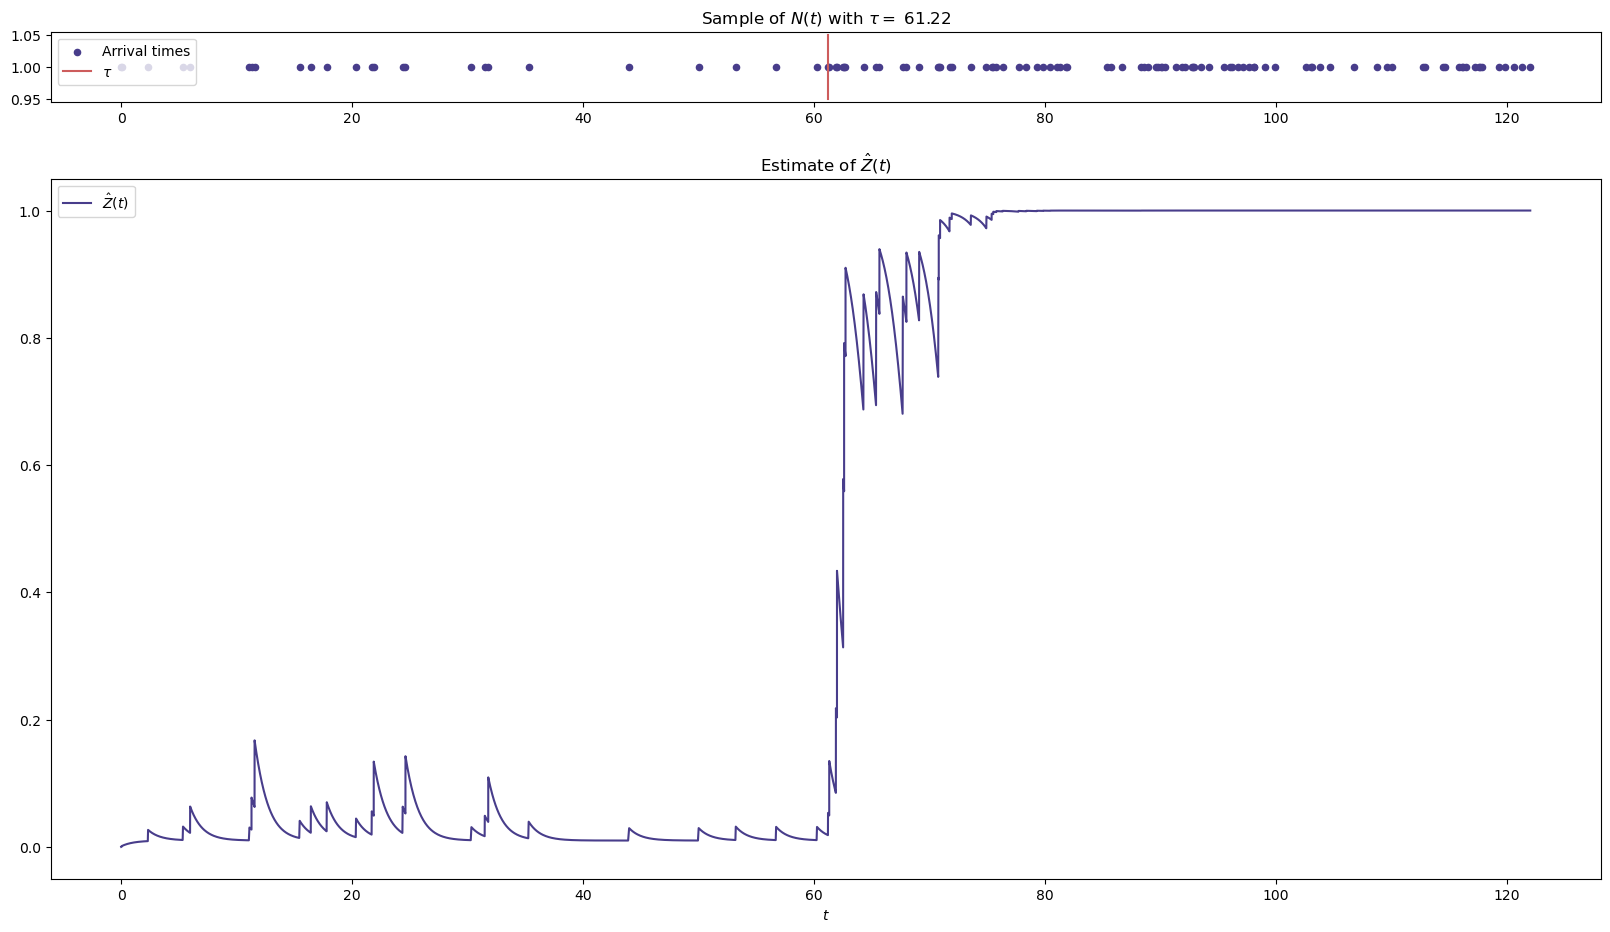

In [7]:
Zhat = Z_hat(T, a, b, sigma, L)
time = np.array([np.linspace(T[k], T[k+1], L, endpoint = False) for k in range(n-1)]).flatten()


f, (a1, a2) = plt.subplots(2, 1, height_ratios = [1, 10])
f.set_size_inches(20,11)

a1.scatter(T, np.ones(n), s = 20, c = 'darkslateblue', label = "Arrival times")
a1.plot([tau] * 10, np.linspace(0.95, 1.05, 10), c="indianred", label = r"$ \tau $")
a1.legend()
a1.set_title(fr'Sample of $N(t)$ with $\tau = $ {np.round(tau, 2)}')

a2.plot(time , Zhat, label = r'$\hat{Z}(t)$', c = 'darkslateblue')
a2.set_xlabel(r'$t$')
a2.set_title(r'Estimate of $\hat{Z}(t)$')
a2.legend(loc = 'upper left')
plt.show()

---
## Question 3

We want here to determine a way to deduce $\tau$ from the computation of $\hat{Z}$ we have. If we look at the general shape of $\hat{Z}$ (plotted above), we can see that the curve is flat, close to 0, then brutally increases to 1. Keeping in mind that $\hat{Z}(t) = \mathbb{P}[\tau \leq t|\mathcal{F}_t]$, this brutal increase can clearly be interpreted as the fact that we just passed $\tau$.  
NB : the closer $a$ and $b$, the less brutal the increase : of course, it is harder to tell if we passed $\tau$ if the processes $N_a$ and $N_b$ are expected to be similar.

Therefore, we are looking for a way to systematically find where this increase happens, and the most natural way to do so is to compute the derivative of $\hat{Z}$. Reminding that $\hat{Z}$ is a solution of the equation :  
$\dot{y}(t) =  (\sigma - (b-a)y(t))(1 - y(t))$  
It is easy to compute $\displaystyle \frac{d\hat{Z}}{dt}$ once we have samples of $\hat{Z}$ (only algebraic manipulations).

The final detail that we have to take into account is that the direction of variation of $\hat{Z}$ (and thus the sign of its derivative) on intervals $\left[T_n, T_{n+1}\right[$ depends on $a$ and $b$. Indeed, if $a < b$ for example, the longer you wait after a jump, the more likely it is that you are still on a low frequency process, i.e that you are still seeing $N_a$, and that you haven't passed $\tau$ yet (and thus $\mathbb{P}[\tau\leq t|\mathcal{F}_t]$, i.e $\hat{Z}(t)$ decreases). The converse is true when $a > b$.

**We therefore need to study the absolute value of $\mathbf{\displaystyle \frac{d\hat{Z}}{dt}}$, and find its argmax.**
\
\
\
Another way to interpret this method of estimation of $\tau$ is to see $\hat{Z}$ as a cumulative distribution function. Indeed, $\hat{Z}(t) = \mathbb{P}[\tau\leq t|\mathcal{F}_t]$, a definition that is very similar to the cdf of $\tau$ (but kind of a "conditionnal cdf", that takes into account our observations). In this way, it's derivative can be seen as a likelihood function, and the method of estimation by maximum likelihood would give us the exact same conclusion :

**Study the absolute value of $\mathbf{\displaystyle \frac{d\hat{Z}}{dt}}$, and find its argmax.**

The estimate of tau is : 62.612912959774064
The value of the error is : 1.39
Which is an error of 1.39% of the expectancy of tau


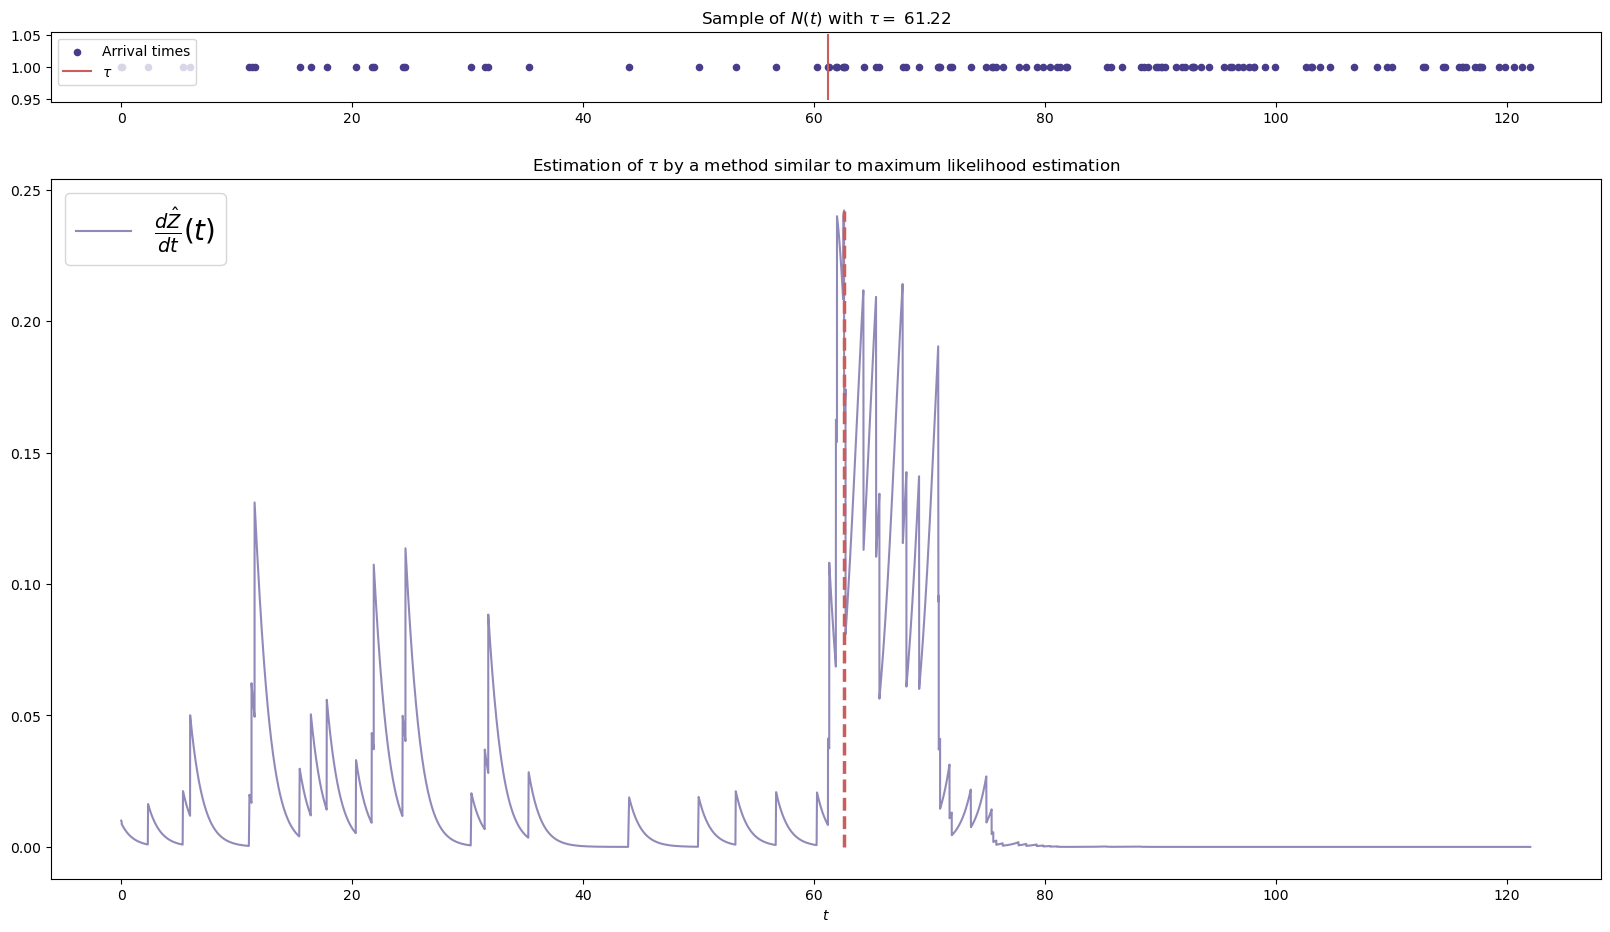

In [8]:
dZhat = np.abs((sigma - (b-a)*Zhat) * (1 - Zhat))
tauhat = time[dZhat.argmax()]
dZmax = dZhat.max()
print("The estimate of tau is :", tauhat)
print("The value of the error is :", np.round(np.abs(tau - tauhat), 2))
print(f"Which is an error of {np.round(100 * np.abs(tau - tauhat) * sigma, 2)}% of the expectancy of tau")

f, (a1, a2) = plt.subplots(2, 1, height_ratios = [1, 10])
f.set_size_inches(20,11)

a1.scatter(T, np.ones(n), s = 20, c = 'darkslateblue', label = "Arrival times")
a1.plot([tau] * 10, np.linspace(0.95, 1.05, 10), c="indianred", label = r"$ \tau $")
a1.legend()
a1.set_title(fr'Sample of $N(t)$ with $\tau = $ {np.round(tau, 2)}')

a2.plot(time, dZhat, label = r"$\frac{d\hat{Z}}{dt}(t)$", c = 'darkslateblue', alpha = 0.6)
a2.plot([tauhat, tauhat], [0, dZmax], lw = 2.5, ls = '--', c = 'indianred')
a2.set_xlabel(r'$t$')
a2.legend(fontsize = 20, loc = 'upper left')
a2.set_title(r'Estimation of $\tau$ by a method similar to maximum likelihood estimation')

plt.show()

Let's test a little bit more the performances of our estimator :

In [9]:
#Number of iterations to compute 
M = 150
res = 0
K = 150

for i in range(M):
    T, tau = simulate(a, b, sigma)
    n = len(T)
    time = np.array([np.linspace(T[k], T[k+1], L, endpoint = False) for k in range(n-1)]).flatten()
    
    Zhat = Z_hat(T, a, b, sigma, L)
    dZhat = np.abs((sigma - (b-a)*Zhat) * (1 - Zhat))
    tauhat = time[dZhat.argmax()]
    res += 100 * np.abs(tau - tauhat) * sigma

print(f"On {M} runs, we got an average error of : {np.round(res/M, 2)}% of the mean of tau")

On 150 runs, we got an average error of : 31.25% of the mean of tau


We can see that even though it's not perfect, our estimation makes pretty satisfying estimations.

## Question 4

We first have to define precisely the problem in a more general case (especially give a sense to $a$ and $b$).  
$\tau$ is defined the exact same way, and we assume that until $\tau$, all $\xi_n := T_n - T_{n-1}$ are i.i.d with $\mathbb{E}[\xi_1] < +\infty$. After $\tau$, the hypothesis are the same but the law that all $\mathcal{E}_n$ follow might be different than the one before.
\
\
We define :  
$\displaystyle a = \frac{1}{\mathbb{E}[\xi_n]}\text{ for } n \text{ such that } T_n < \tau$  
$\displaystyle b = \frac{1}{\mathbb{E}[\xi_n]}\text{ for } n \text{ such that } T_{n-1} > \tau$

Just as before, $a$ and $b$ are the average frequencies of apparition of jumps before and after $\tau$.
\
\
\
Moving on to the estimation of $\tau$. We again want to do so by computing an approximation of $\lambda(t)$ (defined by $\lambda(t) = a + (b-a)\mathbb{1}_{\{\tau\leq t\}}$), and we will discuss the detection of the shift from $a$ to $b$ later. Recall that by definition :

$\displaystyle N(t) = \sum_{n=1}^{\infty}\mathbb{1}_{\{T_n\leq t\}}$

The idea is that for a process with average frequency $a$ (let's call it $N_a$), because $N_a(t)$ is counting the numbers of jump occuring until $t$, and jumps are occuring in average frequency of $a$ jumps per unit of time, we can expect that $N_a(t) \approx at$. Therefore we could expect that :

$\displaystyle N(t) \approx at + (b-a)(t-\tau)\mathbb{1}_{\{\tau\leq t\}}$

Differentiating this w.r.t $t$ would therefore give us an approximation of $\lambda(t)$ (as the RHS of the equation gives exactly $\lambda(t)$ when differentiated). The problem is that $N(t)$ is a step function, and therefore its derivative is just $0$ almost everywhere.  
To compensate this problem, we will define a smoother version of $N$ by computing its moving average. Let $s$ be a given positive real number. We define :

$\boxed{\displaystyle N_{smooth}^{(s)}(t) = \frac{1}{2s}\int_{t-s}^{t+s}N(u)\,du}$

If $A$ is an anti derivative of $N$, then :

$\displaystyle N_{smooth}^{(s)}(t) = \frac{1}{2s}(A(t+s) - A(t-s))$

And therefore :

$\displaystyle \frac{dN_{smooth}^{(s)}}{dt}(t) = \frac{1}{2s}(N(t+s) - N(t-s)) = \frac{1}{2s}\sum_{n=1}^{\infty}\mathbb{1}_{\{t-s < T_n\leq t+s\}}$

It is clear here that $\frac{dN_{smooth}^s}{dt}(t)$ is an approximation of the frequency of the jumps (number of jumps on an interval divided by the size of that interval), and that the bigger $s$, the better the approximation. We therefore have that :

$\boxed{\displaystyle \frac{dN_{smooth}^{(s)}}{dt}(t) \approx a \text{, if } t+s\leq\tau \\ 
\displaystyle \frac{dN_{smooth}^{(s)}}{dt}(t) \approx b \text{, if } t-s\geq\tau}$

And $\mathbf{\frac{dN_{smooth}^{(s)}}{dt}(t)}$ **is a great approximation of** $\mathbf{\lambda(t)}$

Now that we have our estimation of $\lambda(t)$, let's implement it.  
Let's first change the parameters a bit, as the detection technique may be a bit less performant, it could be great to test it in good conditions.

In [10]:
#Setting parameters
a = 5
b = 20
sigma  = 0.01

Let's now define three useful functions : 
 - `generate_N(T, n)` that generates a discrete version of $N$ (with `n` samples) from the jumping times stored in `T`)
 - `moving_average(data, s)` that computes $N_{smooth}^{(s)}$ using a moving average (a discrete version of it of course but that have the exact same effect that te continuous one).
 - `differentiate(N, time)` that differentiates a given discrete version of $N_{smooth}^{(s)}$

We will finally detect the shift using the `ruptures` library (https://ctruong.perso.math.cnrs.fr/ruptures-docs/build/html/detection/window.html).

In [53]:
def generate_N(T, n):
    time = np.linspace(0, T.max(), n)
    res = np.zeros(n)
    k = 0
    for i in range(n):
        if time[i] >= T[k]:
            k += 1
        res[i] = k
    return time, res

def moving_average(data, s):
    window_size = 2*s + 1
    window = np.ones(window_size) / window_size
    data_padded = np.pad(data, (s,s), mode = 'edge')
    return np.convolve(data_padded, window, mode='valid')

def differentiate(N, t_min, t_max):
    M = len(N)
    dN = np.zeros(M)
    dN[0] = 0
    dN[1:] = np.diff(N) * M / (t_max - t_min)
    return dN

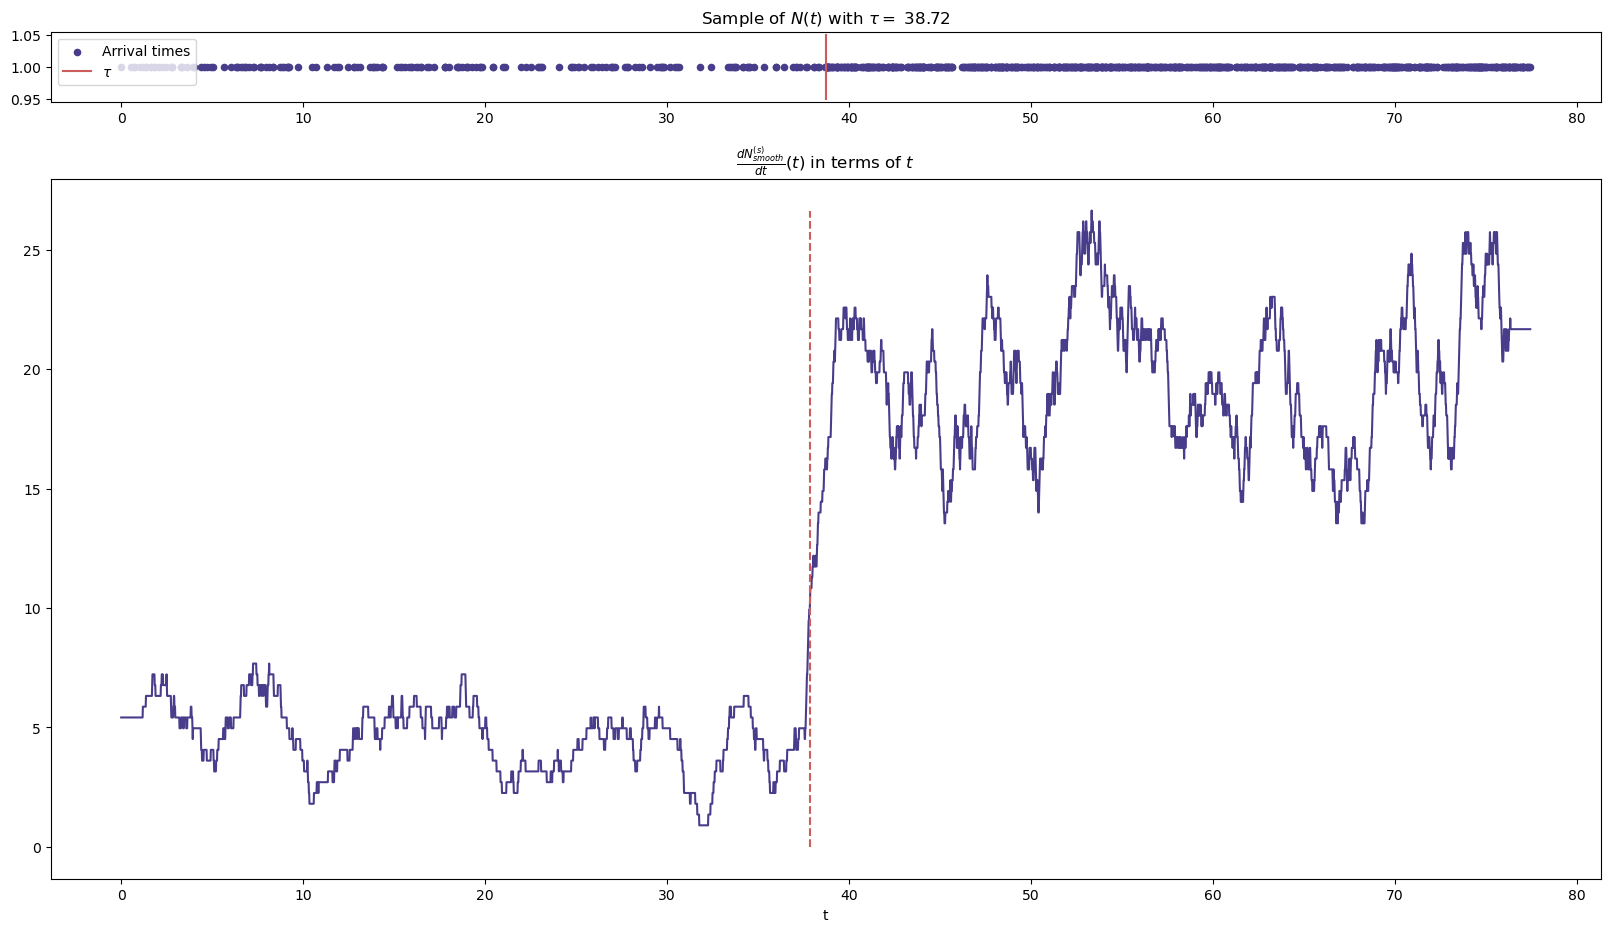

In [56]:
T, tau = simulate(a, b, sigma)
n = len(T)
M = 5000
s = M//70
time, N = generate_N(T, M)
Nsmooth = moving_average(N, s)
dN = differentiate(Nsmooth, 0, time[-1])
dN[:s] = dN[s] * np.ones(s)
dN[M-s:] = dN[M - s] * np.ones(s)

k = rpt.Window().fit_predict(dN, n_bkps = 1)[0]
if k != M:
    tauhat = time[k]

f, (a1, a2) = plt.subplots(2, 1, height_ratios = [1, 10])
f.set_size_inches(20,11)

a1.scatter(T, np.ones(n), s = 20, c = 'darkslateblue', label = "Arrival times")
a1.plot([tau] * 10, np.linspace(0.95, 1.05, 10), c="indianred", label = r"$ \tau $")
a1.legend()
a1.set_title(fr'Sample of $N(t)$ with $\tau = $ {np.round(tau, 2)}')

#a2.plot(time, Nsmooth, c = 'darkslateblue')
a2.plot(time, dN, c = 'darkslateblue')
a2.plot([tauhat, tauhat], [0,dN.max()], c = 'indianred', ls = '--')
a2.set_xlabel('t')
a2.set_title(r'$\frac{dN_{smooth}^{(s)}}{dt}(t)$ in terms of $t$')

plt.show()

Let's finally test the performances of our method :

In [60]:
K = 100 #Number of iterations to compute 
M = 5000 #Number of samples for the computation of N
s = M//70 #Size of the window
res = 0
count = 0

for i in range(K):
    T, tau = simulate(a, b, sigma)
    n = len(T)
    
    time, N = generate_N(T, M)
    N = moving_average(N, s)
    dN = differentiate(Nsmooth, 0, time[-1])
    dN[:s] = dN[s] * np.ones(s)
    dN[M-s:] = dN[M - s] * np.ones(s)
    k = rpt.Window().fit_predict(dN, n_bkps = 1)[0]
    if k != M:
        tauhat = time[k]
        res += 100 * np.abs(tau - tauhat) * sigma
        count += 1

print(f"On {count} runs, we got an average error of : {np.round(res/count, 2)}% of the mean of tau")

On 100 runs, we got an average error of : 2.15% of the mean of tau
